# Lab 3 - Analisis Geoespacial

# Carga de archivos Tiff de bandas B04 y B08 de las dos fehas distintas

In [2]:
import sys
print(sys.executable)


c:\Users\DELL I7\AppData\Local\Programs\Python\Python310\python.exe


In [3]:
# ---------- 1. Archivos ----------
red_2020 = '2020-B04.tiff'
nir_2020 = '2020-B08.tiff'
red_2024 = '2024-B04.tiff'
nir_2024 = '2024-B08.tiff'

# Recorte del bbox y carga a rasterio

In [7]:
import rasterio
from rasterio.windows import from_bounds
# ---------- 2. Recorte ----------
bbox = (-91.0, 16.0, -89.0, 18.0)   # Petén aprox.

with rasterio.open(red_2020) as src:
    win = from_bounds(*bbox, transform=src.transform)
    red20 = src.read(1, window=win).astype('float32')
    profile = src.profile
    profile.update({
        'height': win.height,
        'width':  win.width,
        'transform': src.window_transform(win)
    })

with rasterio.open(nir_2020) as src:
    nir20 = src.read(1, window=win).astype('float32')

with rasterio.open(red_2024) as src:
    red24 = src.read(1, window=win).astype('float32')

with rasterio.open(nir_2024) as src:
    nir24 = src.read(1, window=win).astype('float32')


# Calculo de NDVI

In [8]:
# ---------- 3. NDVI ----------
ndvi20 = (nir20 - red20) / (nir20 + red20)
ndvi24 = (nir24 - red24) / (nir24 + red24)

# ---------- 4. Diferencia y umbral ----------
delta = ndvi24 - ndvi20
forest_loss = delta < -0.2


C:\Users\DELL I7\AppData\Local\Temp\ipykernel_21852\1627154842.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi20 = (nir20 - red20) / (nir20 + red20)
C:\Users\DELL I7\AppData\Local\Temp\ipykernel_21852\1627154842.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi24 = (nir24 - red24) / (nir24 + red24)


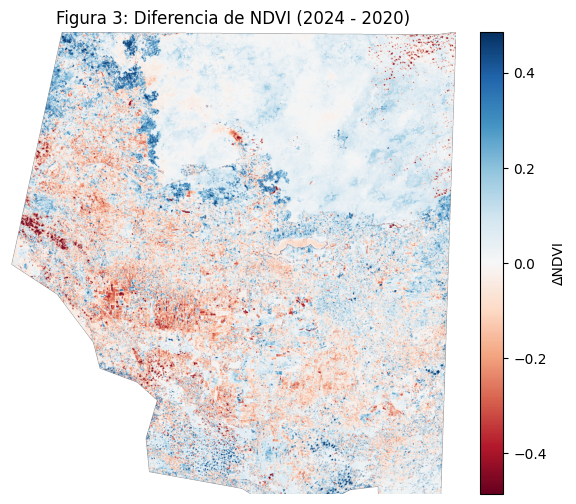

In [18]:
# === Diferencia de NDVI, máscara, figuras y métricas ===
# Requisitos: ndvi20, ndvi24, y 'red_2020' = path a un GeoTIFF de referencia (e.g., 2020-B04.tiff)

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# ---------- 1) Diferencia de NDVI ----------
diff_ndvi = ndvi24 - ndvi20

# Escala robusta para visualización (centra en 0)
v_abs = np.nanpercentile(np.abs(diff_ndvi[np.isfinite(diff_ndvi)]), 99)
vmin, vmax = -v_abs, v_abs

plt.figure(figsize=(8,6))
im = plt.imshow(diff_ndvi, vmin=vmin, vmax=vmax, cmap="RdBu")
plt.title("Figura 3: Diferencia de NDVI (2024 - 2020)")
plt.colorbar(im, fraction=0.046, pad=0.04, label="ΔNDVI")
plt.axis('off')
plt.savefig("fig_diff_ndvi.png", dpi=200, bbox_inches='tight')
plt.show()

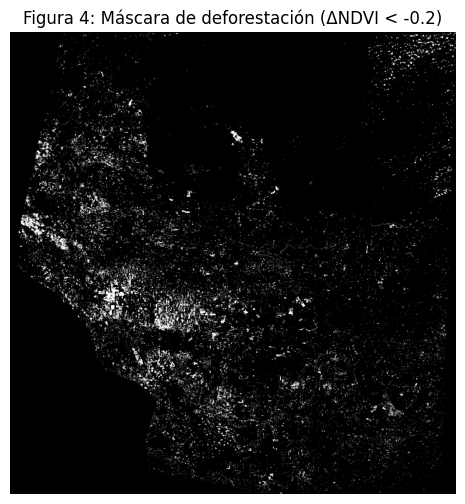

In [19]:
# ---------- 2) Máscara de deforestación ----------
UMBRAL_DEF = -0.2  # ajusta si justificas otro valor
mask_def = np.isfinite(diff_ndvi) & (diff_ndvi < UMBRAL_DEF)

plt.figure(figsize=(8,6))
im = plt.imshow(mask_def, cmap="gray")
plt.title(f"Figura 4: Máscara de deforestación (ΔNDVI < {UMBRAL_DEF})")
plt.axis('off')
plt.savefig("fig_mask_def.png", dpi=200, bbox_inches='tight')
plt.show()

In [20]:
# ---------- 3) Métricas (área en ha y % sobre AOI) ----------
# Reproyectar la máscara a un CRS métrico (UTM 16N) para calcular área correctamente.
ref_path = red_2020         # usa tu variable/path de referencia
dst_crs  = "EPSG:32616"     # UTM zona 16N (métrico para Petén)

with rasterio.open(ref_path) as src:
    src_transform = src.transform
    src_crs       = src.crs
    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds
    )

# Reproyección (nearest para no suavizar la máscara)
mask_uint8   = mask_def.astype("uint8")
mask_reproj  = np.zeros((height, width), dtype="uint8")
reproject(
    source=mask_uint8,
    destination=mask_reproj,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Área por píxel (m²) en UTM
pixel_area_m2 = abs(transform.a * transform.e)

loss_pixels   = np.count_nonzero(mask_reproj == 1)
total_pixels  = mask_reproj.size

area_def_ha   = (loss_pixels * pixel_area_m2) / 10_000
percent_def   = (loss_pixels / total_pixels) * 100

print(f"Área deforestada: {area_def_ha:,.2f} ha")
print(f"Porcentaje sobre el AOI: {percent_def:.2f} %")

Área deforestada: 154,892.25 ha
Porcentaje sobre el AOI: 2.82 %


In [21]:
# ---------- 4) Observación automática (cuadrantes) ----------
h, w = mask_reproj.shape
mid_h, mid_w = h // 2, w // 2

nw = np.count_nonzero(mask_reproj[:mid_h, :mid_w] == 1)  # arriba-izquierda
ne = np.count_nonzero(mask_reproj[:mid_h,  mid_w:] == 1) # arriba-derecha
sw = np.count_nonzero(mask_reproj[ mid_h:, :mid_w] == 1) # abajo-izquierda
se = np.count_nonzero(mask_reproj[ mid_h:,  mid_w:] == 1) # abajo-derecha

quad_counts = {"Noroeste (NW)": nw, "Noreste (NE)": ne, "Suroeste (SW)": sw, "Sureste (SE)": se}
zona_max = max(quad_counts, key=quad_counts.get)
pct_zona_max = 100 * quad_counts[zona_max] / max(1, loss_pixels)

print(f"Observación: La mayor concentración de pérdida de cobertura vegetal se localiza en el sector {zona_max} (~{pct_zona_max:.1f}% de los píxeles con pérdida).")
print("Figuras guardadas: fig_diff_ndvi.png, fig_mask_def.png")

Observación: La mayor concentración de pérdida de cobertura vegetal se localiza en el sector Suroeste (SW) (~42.0% de los píxeles con pérdida).
Figuras guardadas: fig_diff_ndvi.png, fig_mask_def.png


# Calculo porcentual de area deforestada

In [10]:
import numpy as np 

# ---------- 5. Área deforestada ----------
pixel_area = abs(profile['transform'][0] * profile['transform'][4])  # m²
total_pixels = red20.size
loss_pixels = np.sum(forest_loss)
percent_loss = (loss_pixels / total_pixels) * 100
print(f"Área deforestada: {percent_loss:.2f} % del área analizada")

Área deforestada: 3.90 % del área analizada


# Visualizacion de los mapas

Matplotlib is building the font cache; this may take a moment.


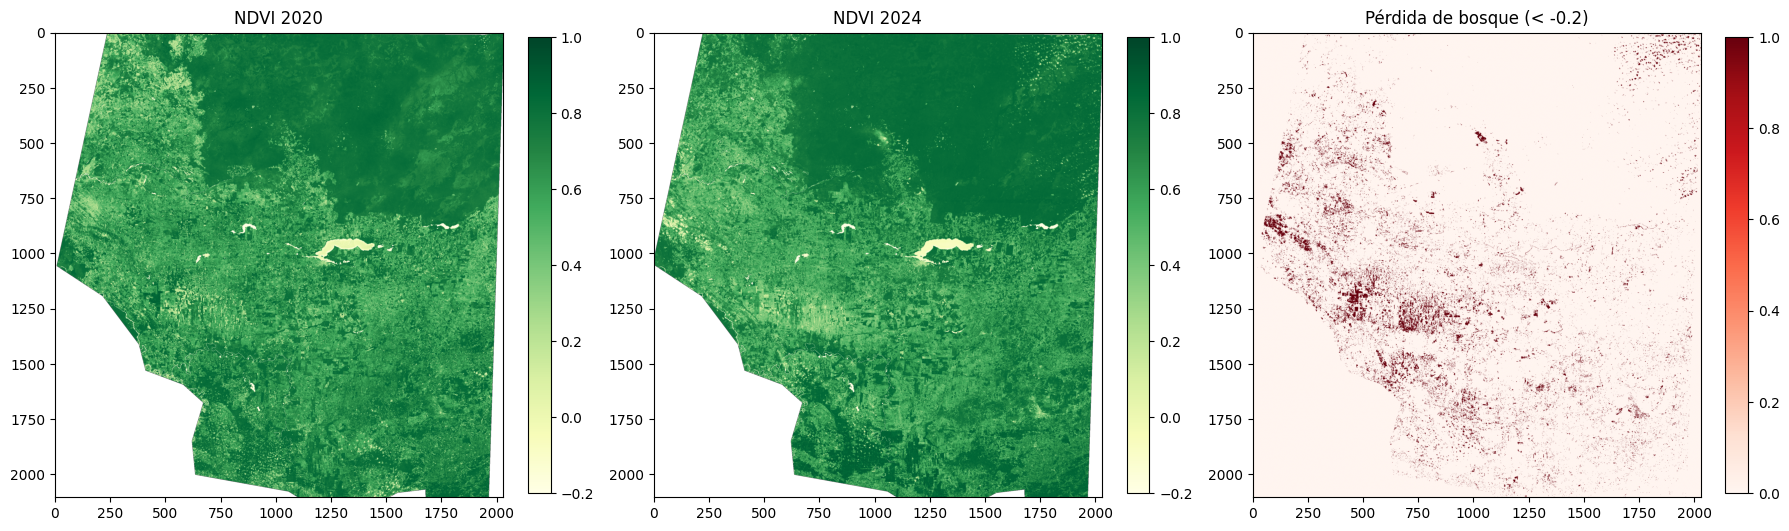

In [17]:
import matplotlib.pyplot as plt



# ---------- 6. Visualización ----------
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
im0 = ax[0].imshow(ndvi20, cmap='YlGn', vmin=-0.2, vmax=1)
ax[0].set_title('NDVI 2020')
plt.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(ndvi24, cmap='YlGn', vmin=-0.2, vmax=1)
ax[1].set_title('NDVI 2024')
plt.colorbar(im1, ax=ax[1], fraction=0.046)

im2 = ax[2].imshow(forest_loss, cmap='Reds')
ax[2].set_title('Pérdida de bosque (< -0.2)')
plt.colorbar(im2, ax=ax[2], fraction=0.046)

plt.tight_layout()
plt.show()